In [2]:
import os
import time
from tqdm import tqdm
import ast

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns


from surprise import BaselineOnly, Dataset, Reader
from surprise.model_selection import cross_validate

In [3]:
import joblib

In [4]:
from IPython.display import Markdown, display

In [5]:
cm = sns.light_palette("green", as_cmap=True)

In [6]:
userRatings = pd.read_csv("../data/reducedUserRatings.csv", index_col=0) # issues with outliers and usernames already fixed

In [7]:
userRatings.groupby("BGGId").size().describe()

count    9640.000000
mean        6.783402
std        55.875311
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max      2927.000000
dtype: float64

In [8]:
userRatings.groupby("reducedUsername").size().describe()

count    13060.000000
mean         5.007044
std         12.717586
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        474.000000
dtype: float64

In [9]:
def naturalNumber(val):
    """Find all non-natural number ratings"""
    return round(val) ==val

## ADDITION EDA

In [10]:
userRatings["isNatural"] = userRatings.Rating.apply(lambda x: naturalNumber(x))

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<AxesSubplot: xlabel='isNatural', ylabel='Count'>

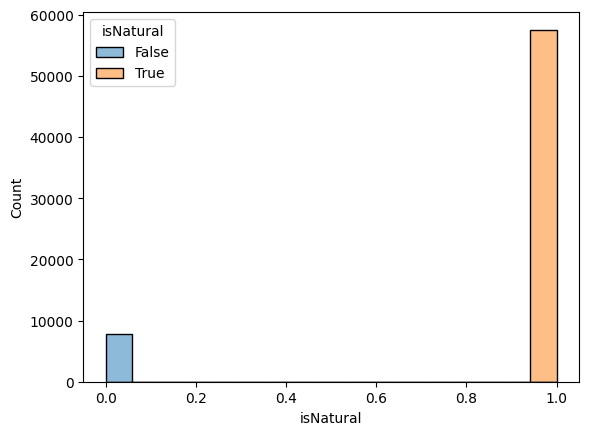

In [11]:
sns.histplot(data=userRatings,x="isNatural",hue="isNatural")

In [12]:
userRatings["Rating"] = userRatings.Rating.apply(lambda x: round(x))

In [13]:
# Number of users 
userRatings.reducedUsername.unique().shape[0]

13060

In [14]:
# Number of items
userRatings.BGGId.unique().shape[0]

9640

In [15]:
# Rating properties

In [79]:
longtail = userRatings.groupby("BGGId").size().sort_values(ascending=False).reset_index().rename(columns={0:"rating count"})#.value_counts().sort_index()


In [80]:
longtail

,BGGId,rating count
0,30549,2927
1,822,2920
2,13,2854
3,68448,1598
4,36218,1094
...,...,...
9635,136244,1
9636,288969,1
9637,246409,1
9638,198881,1


AttributeError: Rectangle.set() got an unexpected keyword argument 'figsize'

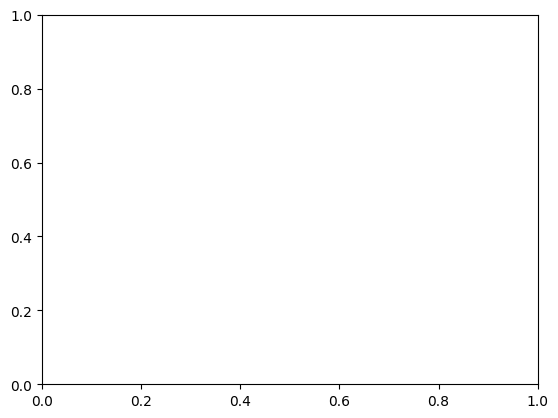

In [85]:

sns.barplot(x="BGGId", y="rating count",
            data=longtail[longtail["rating count"] >500].sort_values(by="rating count"),
           figsize=(10,10))

Text(0, 0.5, 'No. of ratings')

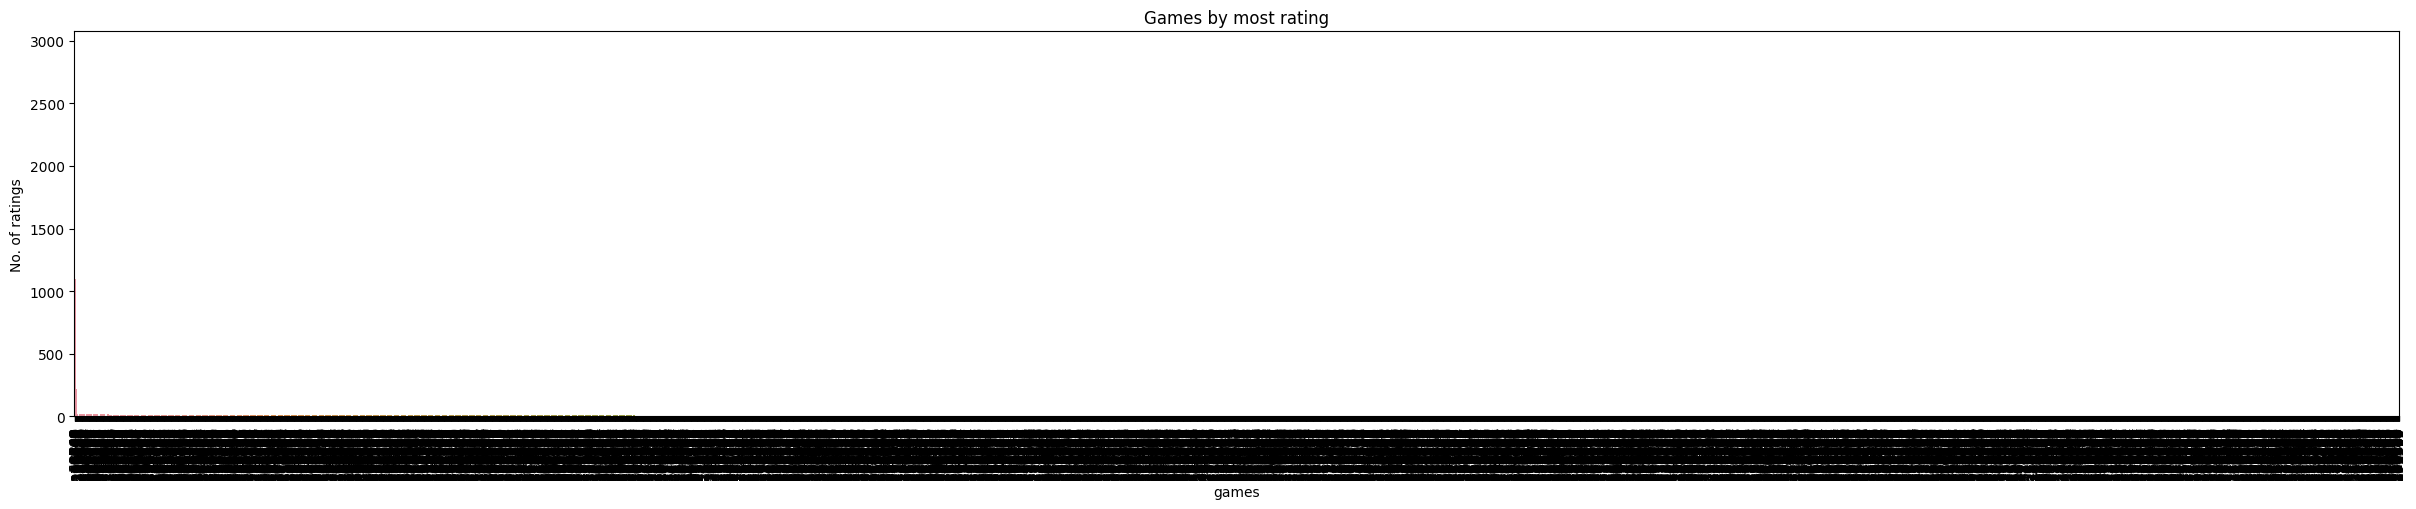

In [88]:
plt.figure(figsize=(30, 5))
highest_sport = userRatings['BGGId'].value_counts().index
sns.countplot(data=userRatings, x='BGGId', order=highest_sport)
plt.xticks(rotation=90)
plt.title('Games by most rating')
plt.xlabel('games')
plt.ylabel('No. of ratings')


In [16]:
def distplot(figRows,figCols,xSize, ySize, data, features, colors, kde=True, bins=None):
    f, axes = plt.subplots(figRows, figCols, figsize=(xSize, ySize))
    
    features = np.array(features).reshape(figRows, figCols)
    colors = np.array(colors).reshape(figRows, figCols)
    
    for row in range(figRows):
        for col in range(figCols):
            if (figRows == 1 and figCols == 1) :
                axesplt = axes
            elif (figRows == 1 and figCols > 1) :
                axesplt = axes[col]
            elif (figRows > 1 and figCols == 1) :
                axesplt = axes[row]
            else:
                axesplt = axes[row][col]
            plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})
            plot.set_xlabel(features[row][col],fontsize=20)

def scatterplot(rowFeature, colFeature, data):
    f, axes = plt.subplots(1, 1, figsize=(10, 8))
        
    plot=sns.scatterplot(x=rowFeature, y=colFeature, data=data, ax=axes)
    plot.set_xlabel(rowFeature,fontsize=20)
    plot.set_ylabel(colFeature,fontsize=20)  

In [17]:
pal = sns.color_palette(palette='Set1', n_colors=16)


/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_2219/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


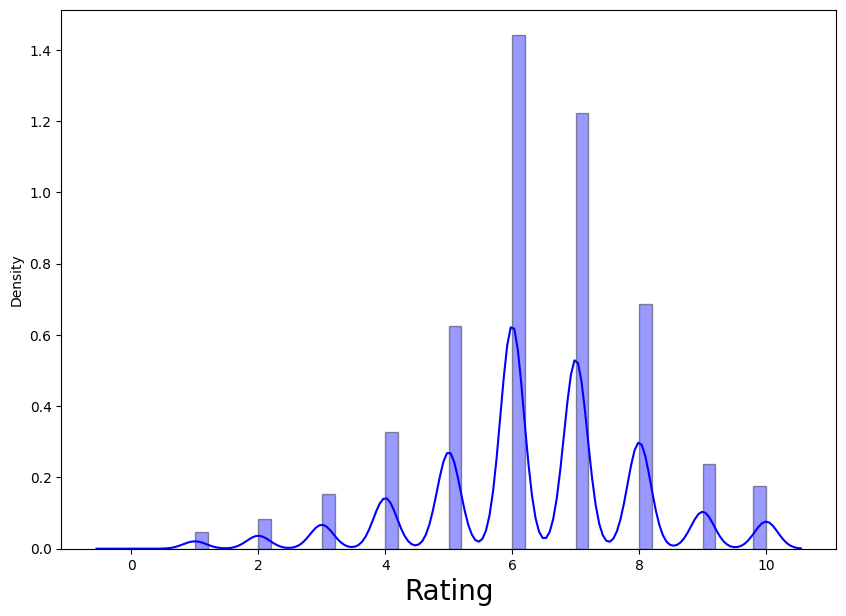

In [18]:
# Rating Distribution

distplot(1, 1, 10, 7, data=userRatings, features=['Rating'], colors=['blue'])

In [19]:
groupby_products_Ratings = userRatings.groupby('BGGId')['Rating']

ratings_products = pd.DataFrame(groupby_products_Ratings.count().clip(upper=30))
ratings_products.rename(columns={"Rating": "Rating_Count"}, inplace=True)

In [20]:
(groupby_products_Ratings.count() ==1).sum()

889

In [21]:
(groupby_products_Ratings.count() ==1).sum()/userRatings.BGGId.unique().shape[0]

0.09221991701244814

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_2219/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


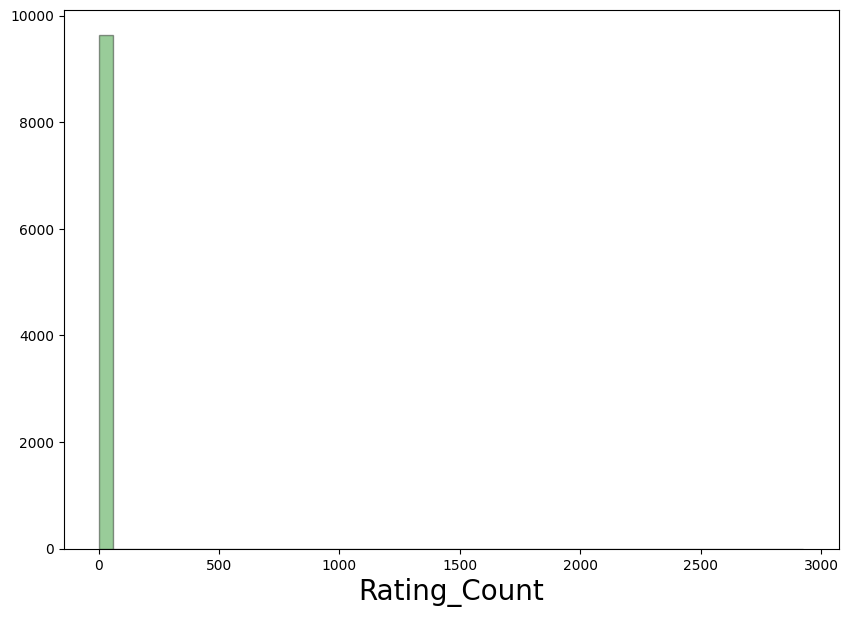

In [22]:
#Count Distribution grouped by Products
distplot(1, 1, 10, 7, data=pd.DataFrame(groupby_products_Ratings.count()).rename(columns={"Rating": "Rating_Count"}), features=['Rating_Count'], colors=['green'], kde=False)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_2219/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


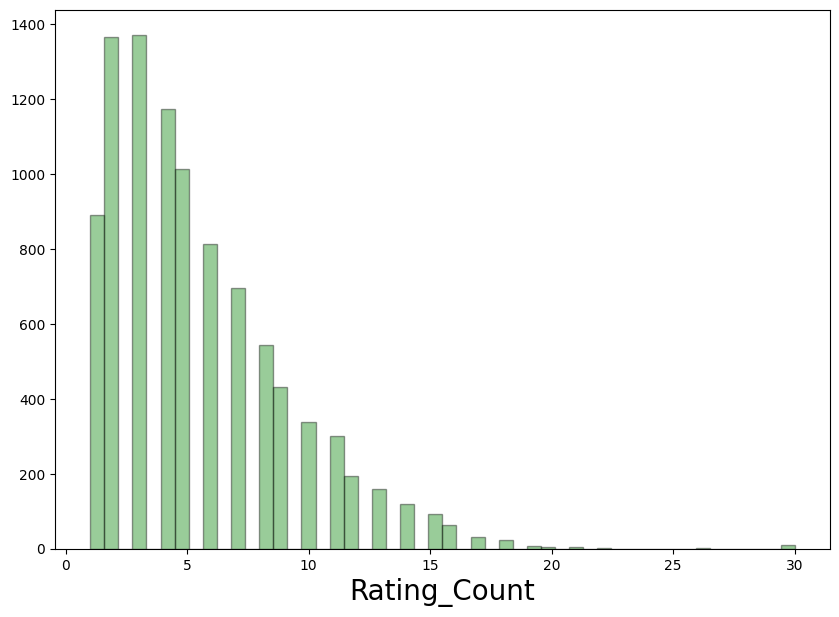

In [23]:
# Top Rating Count Distribution grouped by Products upper 30
distplot(1, 1, 10, 7, data=ratings_products, features=['Rating_Count'], colors=['green'], kde=False)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_2219/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


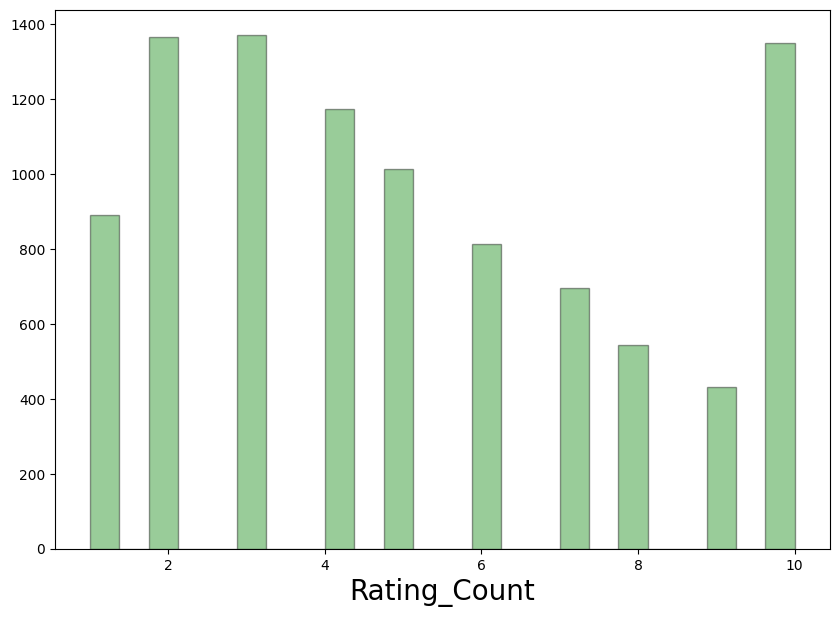

In [24]:
# Top Rating Count Distribution grouped by Products
distplot(1, 1, 10, 7, data=pd.DataFrame(groupby_products_Ratings.count().clip(upper=10)).rename(columns={"Rating": "Rating_Count"}), features=['Rating_Count'], colors=['green'], kde=False)

In [25]:
groupby_users_Ratings = userRatings.groupby('reducedUsername')['Rating']
rating_users = pd.DataFrame(groupby_users_Ratings.count().clip(lower=1, upper=100))
rating_users.rename(columns={"Rating": "Rating_Count"}, inplace=True)

In [26]:
(groupby_users_Ratings.count() ==1).sum()

5018

In [27]:
(groupby_users_Ratings.count() ==1).sum()/userRatings.reducedUsername.unique().shape[0]

0.3842266462480858

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_2219/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


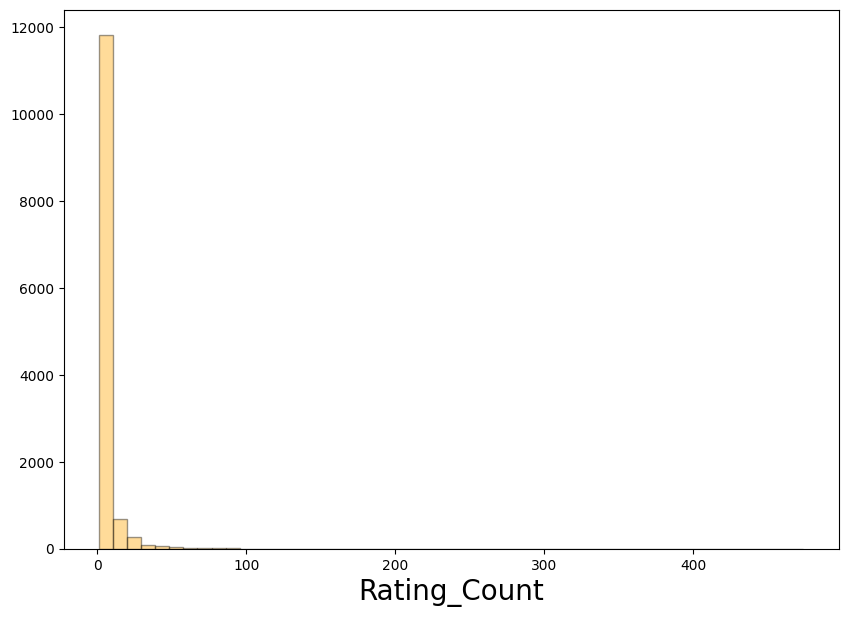

In [28]:
# Top Rating Count Distribution grouped by Users
distplot(1, 1, 10, 7, data=pd.DataFrame(groupby_users_Ratings.count()).rename(columns={"Rating": "Rating_Count"}), features=['Rating_Count'], colors=['orange'], kde=False)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_2219/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


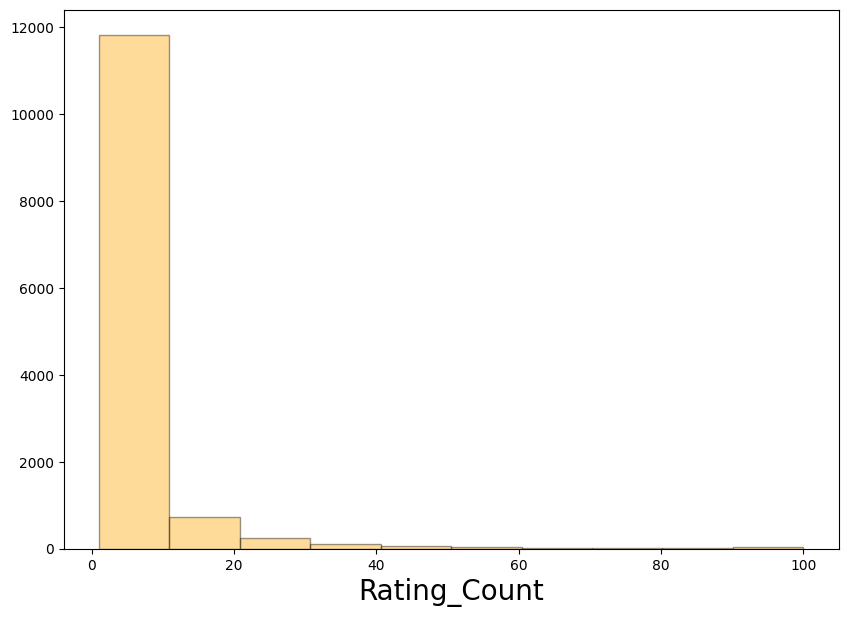

In [29]:
# Top Rating Count Distribution grouped by Users
distplot(1, 1, 10, 7, data=rating_users, features=['Rating_Count'], colors=['orange'], kde=False, bins=10)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_2219/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


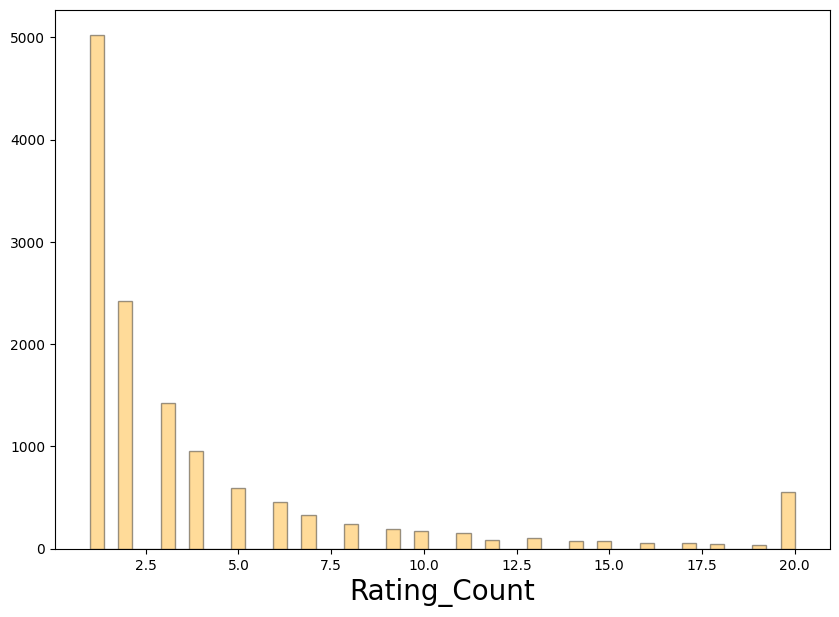

In [30]:
# Top Rating Count Distribution grouped by Users
distplot(1, 1, 10, 7, data=pd.DataFrame(groupby_users_Ratings.count().clip(upper=20)).rename(columns={"Rating": "Rating_Count"}), features=['Rating_Count'], colors=['orange'], kde=False)

In [31]:
ratings = pd.DataFrame(userRatings.groupby('BGGId')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_2219/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


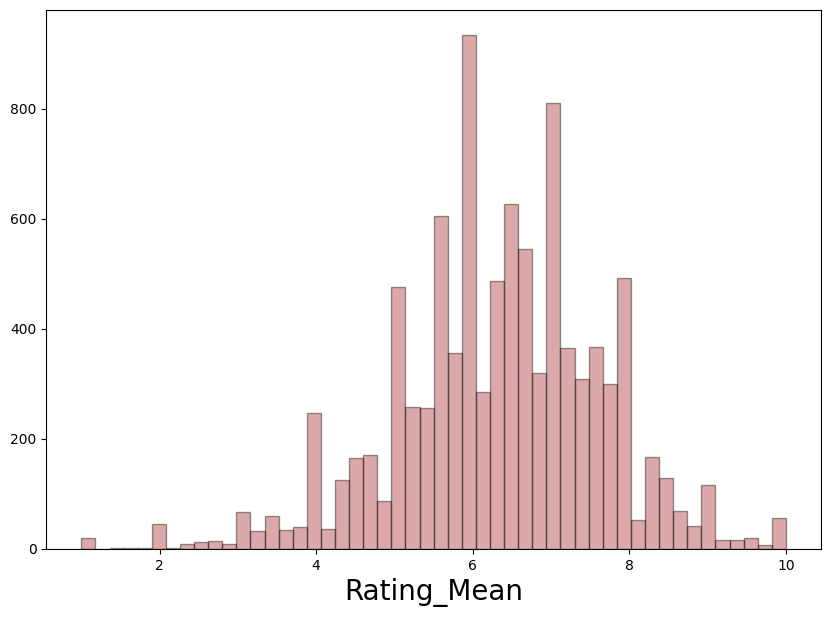

In [32]:
# Mean Rating Distribution grouped by Products
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

In [33]:
ratings['Rating_Count'] = userRatings.groupby('BGGId')['Rating'].count()

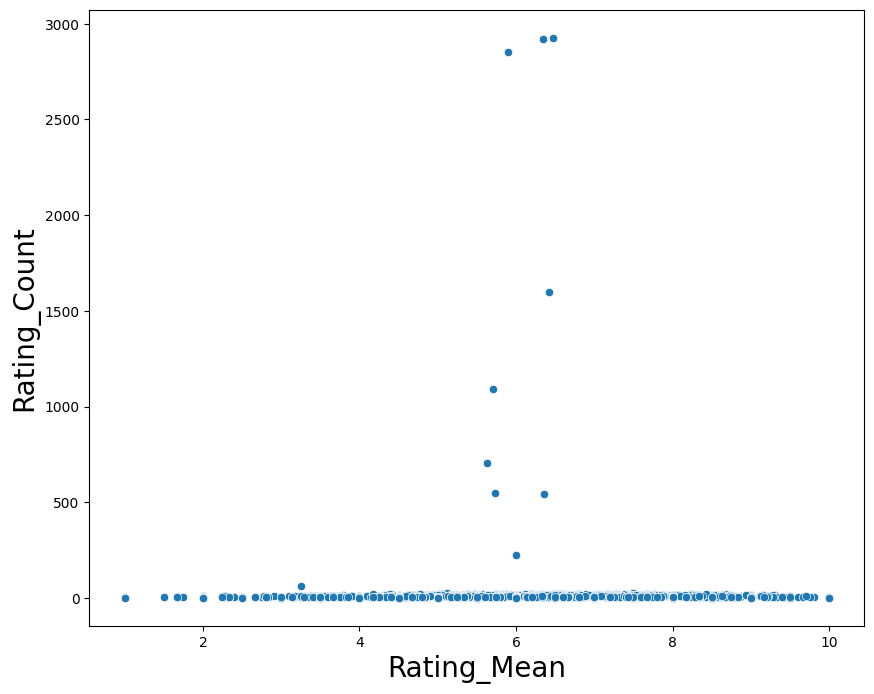

In [34]:
# Mean Rating - Rating Count Distribution grouped by Products
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

/var/folders/ck/bcrpxpw173z_zbvmzgxf02v80000gp/T/ipykernel_2219/3849997611.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})


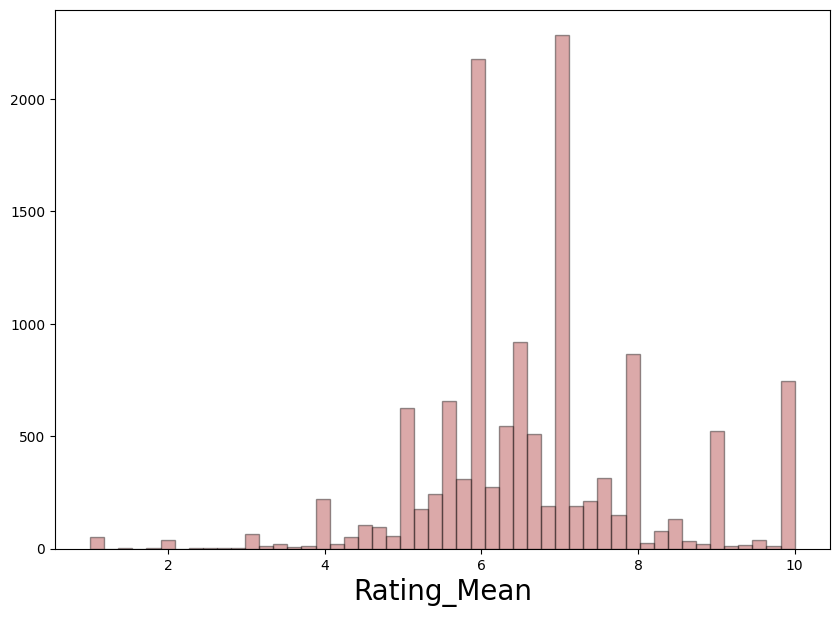

In [35]:
# Mean Rating Distribution grouped by Users
ratings = pd.DataFrame(userRatings.groupby('reducedUsername')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

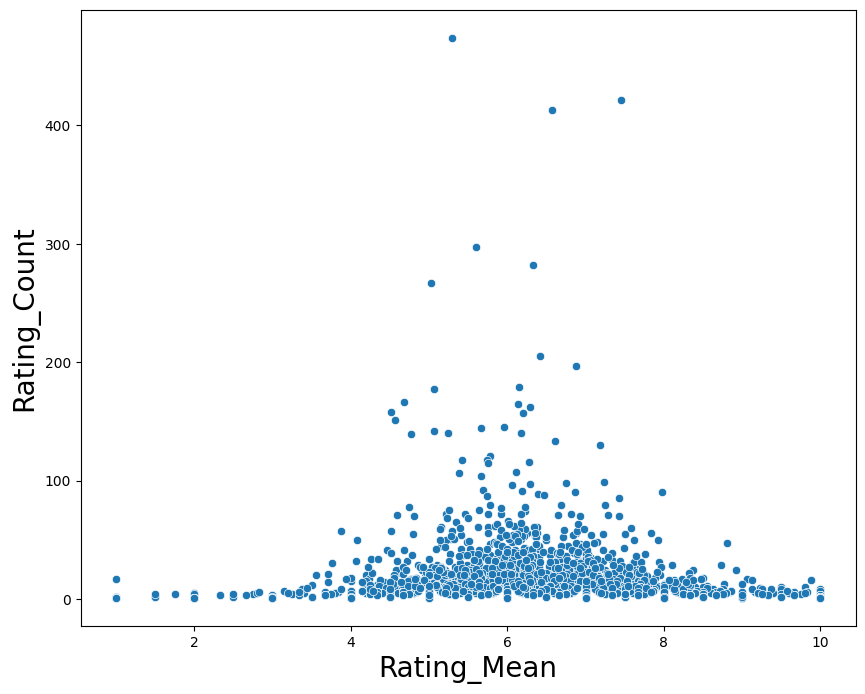

In [36]:
# Mean Rating - Rating Count Distribution grouped by Users
ratings['Rating_Count'] = userRatings.groupby('reducedUsername')['Rating'].count()
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

# BASIC CF AS IMPLEMETED IN [SURPRISE](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html)

In [37]:
from surprise import BaselineOnly, Dataset, Reader, dataset
from surprise.model_selection import cross_validate,RandomizedSearchCV,GridSearchCV, KFold
from surprise import KNNWithMeans,KNNWithZScore,SVD,KNNBaseline,KNNBasic
from surprise import accuracy

from sklearn.pipeline import Pipeline

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
# Let's keep a subset of the data for final testing
trainset, testset = train_test_split(userRatings, test_size=.3, random_state=10)

In [56]:
display(trainset.shape)
display(trainset.BGGId.unique().shape)
display(trainset.reducedUsername.unique().shape)

(45774, 5)

(9205,)

(11340,)

In [40]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 10))

# The columns must correspond to user id, item id and ratings (in that order).
traindata = Dataset.load_from_df(trainset[["reducedUsername", "BGGId", "Rating"]], reader)

In [41]:
traindata.has_been_split

False

In [42]:
# Since we cannot do pipeline Gridsearch, we will fix the cross valdiation folds for model comparison
cv = KFold(n_splits=3, shuffle=False, random_state = 100)

In [43]:
# model_list = {"KNNBasic_pearson_user":KNNBasic(sim_options={'name':'pearson' , 'user_based':True}),
#              "KNNBasic_pearson_item":KNNBasic(sim_options={'name':'pearson' , 'user_based':False}),
#              "KNNBasic_cosine_user":KNNBasic(sim_options={'name':'cosine' , 'user_based':True, "min_support":2}),
#              "KNNBasic_cosine_item":KNNBasic(sim_options={'name':'cosine' , 'user_based':False,"min_support":2}),
#              "KNNBasic_MSD_user":KNNBasic(sim_options={'name':'MSD' , 'user_based':True}),
#              "KNNBasic_MSD_item":KNNBasic(sim_options={'name':'MSD' , 'user_based':False}),
#              "KNNBasic_pearson_baseline_user":KNNBasic(sim_options={'name':'pearson_baseline' , 'user_based':True}),
#              "KNNBasic_pearson_baseline_item":KNNBasic(sim_options={'name':'pearson_baseline' , 'user_based':False}),
              
#              "KNNWithZScore_pearson_user":KNNWithZScore(sim_options={'name':'pearson' , 'user_based':True}),
#              "KNNWithZScore_pearson_item":KNNWithZScore(sim_options={'name':'pearson' , 'user_based':False}),
#              "KNNWithZScore_cosine_user":KNNWithZScore(sim_options={'name':'cosine' , 'user_based':True}),
#              "KNNWithZScore_cosine_item":KNNWithZScore(sim_options={'name':'cosine' , 'user_based':False}),
#              "KNNWithZScore_MSD_user":KNNWithZScore(sim_options={'name':'MSD' , 'user_based':True}),
#              "KNNWithZScore_MSD_item":KNNWithZScore(sim_options={'name':'MSD' , 'user_based':False}),
#              "KNNWithZScore_pearson_baseline_user":KNNWithZScore(sim_options={'name':'pearson_baseline' , 'user_based':True}),
#              "KNNWithZScore_pearson_baseline_item":KNNWithZScore(sim_options={'name':'pearson_baseline' , 'user_based':False}),

#              "KNNWithMeans_pearson_user":KNNWithMeans(sim_options={'name':'pearson' , 'user_based':True}),
#              "KNNWithMeans_pearson_item":KNNWithMeans(sim_options={'name':'pearson' , 'user_based':False}),
#              "KNNWithMeans_cosine_user":KNNWithMeans(sim_options={'name':'cosine' , 'user_based':True}),
#              "KNNWithMeans_cosine_item":KNNWithMeans(sim_options={'name':'cosine' , 'user_based':False}),
#              "KNNWithMeans_MSD_user":KNNWithMeans(sim_options={'name':'MSD' , 'user_based':True}),
#              "KNNWithMeans_MSD_item":KNNWithMeans(sim_options={'name':'MSD' , 'user_based':False}),
#              "KNNWithMeans_pearson_baseline_user":KNNWithMeans(sim_options={'name':'pearson_baseline' , 'user_based':True}),
#              "KNNWithMeans_pearson_baseline_item":KNNWithMeans(sim_options={'name':'pearson_baseline' , 'user_based':False}),
              
#              "KNNBaseline_pearson_user":KNNBaseline(sim_options={'name':'pearson' , 'user_based':True}),
#              "KNNBaseline_pearson_item":KNNBaseline(sim_options={'name':'pearson' , 'user_based':False}),
#              "KNNBaseline_cosine_user":KNNBaseline(sim_options={'name':'cosine' , 'user_based':True}),
#              "KNNBaseline_cosine_item":KNNBaseline(sim_options={'name':'cosine' , 'user_based':False}),
#              "KNNBaseline_MSD_user":KNNBaseline(sim_options={'name':'MSD' , 'user_based':True}),
#              "KNNBaseline_MSD_item":KNNBaseline(sim_options={'name':'MSD' , 'user_based':False}),
#              "KNNBaseline_pearson_baseline_user":KNNBaseline(sim_options={'name':'pearson_baseline' , 'user_based':True}),
#              "KNNBaseline_pearson_baseline_item":KNNBaseline(sim_options={'name':'pearson_baseline' , 'user_based':False}),
             
#              "SVD":SVD( n_epochs=50)}

In [44]:
# Here the metrics are the average scores over the cross validation folds
# results = pd.DataFrame(index= model_list.keys(), columns=['test_rmse','test_mae','fit_time','test_time'])

In [45]:
# %%time
# for i,v in enumerate(model_list):
#     print(v)
#     dictonary = cross_validate(model_list[v], traindata, cv=cv, verbose=True,)
#     for key in dictonary.keys():
#         results.loc[v,key] = np.mean((dictonary[key]))

In [46]:
# results.sort_values(by=['test_rmse','test_mae'], ascending=True).style.bar(color='#d65f5f')

## Gridsearch for tuning some parameters

In [47]:
model_dict = {"KNNBasic":KNNBasic,
             "KNNWithZScore":KNNWithZScore,
             "KNNWithMeans":KNNWithMeans,
             "SVD": SVD,
             "KNNBaseline":KNNBaseline
             }



In [48]:
similarities = ["pearson",
                "cosine",
                "MSD",
                "pearson_baseline"
                ]

In [49]:
param_dict = {"KNNBasic":{
                            'k': [101],
                            'sim_options': {
                                'name': similarities,
                                'min_support': list(range(2,20,2)),
                                'user_based': [False, True],
                                'shrinkage': [0,5,10,20,100]
                            },
                        },
              "KNNWithZScore":{
                            'k': [101],
                            'sim_options': {
                                'name': similarities,
                                'min_support': list(range(2,20,2)),
                                'user_based': [False, True],
                                'shrinkage': [0,5,10,20,100]
                            },
                        },
                "KNNWithMeans":{
                            'k': [101],
                            'sim_options': {
                                'name': similarities,
                                'min_support': list(range(2,20,2)),
                                'user_based': [False, True],
                                'shrinkage': [0,5,10,20,100]
                            },
                        },
              "KNNBaseline":{
                            'k': [101],
                            'sim_options': {
                                'name': similarities,
                                'min_support': list(range(2,20,2)),
                                'user_based': [False, True],
                                'shrinkage': [0,5,10,20,100]
                            },
                          "bsl_options" : {
                                    "method": ['sgd'],#,
                                    #'reg_i' :[0,5,10],
                                    #'reg_u' : [0,5,10],
                                    'reg': [0.02,0.08,0.5],
                                    "learning_rate": [0.005,0.01,0.05],
                                    'n_epochs': [100]
                                }
                        },
              "SVD":{"n_factors": [10,50,100,150,200], # latent factors
                     "n_epochs": [20,30,40], # sgd iteration
                     "lr_all": [0.002, 0.004,0.006,0.008,0.01], # learning rate of gradient decent
                     "reg_all": [0.02, 0.04,0.06,0.08,0.1], # reg for all parameters
                     "biased": [False, True]}
            
             
             
             
             
             
             
             }

In [50]:
def printmd(string, color=None):
    '''Print to track progress'''
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [51]:
gs_results= pd.DataFrame()

#### Traing all defined models dictionary

In [52]:
%%time
for i in model_dict:
    printmd(f"**{i}**", color="blue")
    model = model_dict[i]
    parameters = param_dict[i]
    
    gs = GridSearchCV(model, parameters, measures=["rmse", "mae", "fcp"], cv=cv)
    gs.fit(traindata)
    joblib.dump(gs, i+'_gridsearch.pkl')
    sub = pd.DataFrame.from_dict(gs.cv_results)
    sub["model"] = i
    gs_results = pd.concat([gs_results,sub])
    #display(gs_results.tail(4))
    printmd("**Done**", color="blue")


<span style='color:blue'>**KNNBasic**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computi

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**KNNWithZScore**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computi

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computi

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computin

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**KNNWithMeans**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computi

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computi

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computin

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**SVD**</span>

<span style='color:blue'>**Done**</span>

<span style='color:blue'>**KNNBaseline**</span>

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd.

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Est

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matri

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Comput

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computi

<span style='color:blue'>**Done**</span>

CPU times: user 11h 54min 52s, sys: 3h 29min 3s, total: 15h 23min 56s
Wall time: 15h 42min 23s


In [53]:
gs_results.to_csv("../results/Collaborative filtering/run 2/Wide CF gridsearch results.csv")

In [ ]:
### CMF
!pip install cmfrec

In [64]:
try:
    assert gs_results.shape[0] > 0
except:
    gs_results = pd.read_csv("../results/Collaborative filtering/CF gridsearch results.csv",index_col=0)

In [89]:
def resultExtractor(val,feature):
    try:
        return ast.literal_eval(val)[feature]
    except:
        return np.nan

In [90]:
gs_results["user_based"] = gs_results.param_sim_options.apply(lambda x: resultExtractor(x,"user_based"))

In [92]:
gs_results["similarity"] = gs_results.param_sim_options.apply(lambda x: resultExtractor(x,'name'))

In [56]:
gs_results#["similarity"]

""


In [95]:
gs_results[gs_results.model != "SVD"].sort_values(by=['rank_test_rmse','rank_test_mae'])[['model','similarity','user_based','rank_test_rmse','rank_test_mae','mean_test_rmse','mean_test_mae']]

,model,similarity,user_based,rank_test_rmse,rank_test_mae,mean_test_rmse,mean_test_mae
71,KNNBasic,pearson_baseline,True,1,1,1.693669,1.296647
71,KNNWithZScore,pearson_baseline,True,1,1,1.669242,1.245453
71,KNNWithMeans,pearson_baseline,True,1,1,1.669209,1.245472
70,KNNBasic,pearson_baseline,True,2,2,1.693670,1.296648
70,KNNWithZScore,pearson_baseline,True,2,2,1.669242,1.245453
...,...,...,...,...,...,...,...
23,KNNBasic,cosine,True,71,71,1.704240,1.303512
38,KNNWithZScore,MSD,False,71,71,1.745909,1.305118
37,KNNWithMeans,MSD,False,72,69,1.744663,1.304246
21,KNNBasic,cosine,True,72,70,1.704240,1.303512


In [52]:
# Next questions to address
# Why does cosine similarity result in zero division for small minimum support like 1?

# Can and should we manually adjust the search space for minimum data based on training data distribution?

In [ ]:

####################################################################################################################


#### Lets build a pipeline for hyperparameter tuning and model selection all at once

In [ ]:
# from enum import Enum
# class Model(Enum):
#     KNNWithZScore='z standrdized CF'
#     KNNWithMeans='baseline centered CF'
#     all= 'best model'



# model_list = [e for e in Model if e != Model.all]
# model_instances = []
# params = []

# num_folds = 5  # Hard coded
# scoring = ['rmse', 'mae']

# #clf1 = KNNWithZScore(verbose=True)
# #param1 = {}
# #param1['k'] = [50]
# #param1['sim_options'] =  {
# #                                        'name': ['pearson', 'cosine'],
# #                                        'min_support': [1, 5],
# #                                        'user_based': [False, True],
# #                                    }
# #param1['regressor'] = [clf1]
# #model_instances.append(clf1)
# #params.append(param1)

# gs = GridSearchCV(clf1, param1, cv=num_folds, measures=scoring, refit=True,joblib_verbose=2)


# gs.fit(traindata)

# if Model.KNNWithZScore in model_list:
#         clf1 = KNNWithZScore#(verbose=True)
#         param1 = {}
#         param1['regressor__k'] = [50]
#         param1['regressor__sim_options'] =  {
#                                                 'name': ['pearson', 'cosine'],
#                                                 'min_support': [1, 5],
#                                                 'user_based': [False, True],
#                                             },
#         param1['regressor'] = [clf1]
#         model_instances.append(clf1)
#         params.append(param1)


        
# pipeline = Pipeline([('regressor', model_instances[0])])


# gs = GridSearchCV(pipeline, params, cv=num_folds, measures=scoring, refit=True,joblib_verbose=2)

# gs.fit(traindata)


In [ ]:
# sim_options = {
#     "name": ["msd", "cosine", "pearson", "pearson_baseline"],
#     #"min_support": [3, 4, 5],
#     "user_based": [False],
# }

In [ ]:
# knn_model = KNNWithMeans(k=10,sim_options={'name':'pearson' , 'user_based':True})
# knn_model.fit(traindata)

In [ ]:
# accuracy.rmse(test_pred_knn)

In [ ]:
# #Evaluation on testset

# test_pred_knn=knn_model.test(testset)

# # compute RMSE
# accuracy.rmse(test_pred_knn)

In [ ]:
# test_pred_df = pd.DataFrame(test_pred_knn)

In [ ]:
# test_pred_df.sort_values(by=["uid","iid","r_ui"], ascending=False)

In [ ]:
# # Use the famous SVD algorithm.
# algo = SVD()

# # Run 5-fold cross-validation and print results.
# cross_validate(algo, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
# sim_options = {
#     "name": ["msd", "cosine", "pearson", "pearson_baseline"],
#     "min_support": [3, 4, 5],
#     "user_based": [True],
# }

In [ ]:
# cross_validate(KNNWithZScore(sim_options=sim_options), traindata, cv=2)

In [ ]:
# cv_result = cross_validate(KNNWithZScore(sim_options=sim_options), trainset, cv=5)

In [ ]:
# from collections import defaultdict

# def get_top_n(predictions, n=10):
#     # First map the predictions to each user.
#     top_n = defaultdict(list)
#     for uid, iid, true_r, est, _ in predictions:
#         top_n[uid].append((iid, est))

#     # Then sort the predictions for each user and retrieve the k highest ones.
#     for uid, user_ratings in top_n.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top_n[uid] = user_ratings[:n]

#     return top_n


In [ ]:
# class collab_filtering_based_recommender_model():
#     def __init__(self, model, trainset, testset, data):
#         self.model = model
#         self.trainset = trainset
#         self.testset = testset
#         self.data = data
#         self.pred_test = None
#         self.recommendations = None
#         self.top_n = None
#         self.recommenddf = None

#     def fit_and_predict(self):        
#         printmd('**Fitting the train data...**', color='brown')
#         self.model.fit(self.trainset)       

#         printmd('**Predicting the test data...**', color='brown')
#         self.pred_test = self.model.test(self.testset)        
#         rmse = round(accuracy.rmse(self.pred_test), 3)
#         printmd('**RMSE for the predicted result is ' + str(rmse) + '**', color='brown')   
        
#         self.top_n = get_top_n(self.pred_test)
#         self.recommenddf = pd.DataFrame(columns=['userId', 'productId', 'Rating'])
#         for item in self.top_n:
#             subdf = pd.DataFrame(self.top_n[item], columns=['productId', 'Rating'])
#             subdf['userId'] = item
#             cols = subdf.columns.tolist()
#             cols = cols[-1:] + cols[:-1]
#             subdf = subdf[cols]        
#             self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)        
#         return rmse
        
#     def cross_validate(self):
#         printmd('**Cross Validating the data...**', color='brown')
#         cv_result = cross_validate(self.model, self.data, n_jobs=-1)
#         cv_result = round(cv_result['test_rmse'].mean(),3)
#         printmd('**Mean CV RMSE is ' + str(cv_result)  + '**', color='brown')
#         return cv_result

#     def recommend(self, user_id, n=5):
#         printmd('**Recommending top ' + str(n)+ ' products for userid : ' + user_id + ' ...**', color='brown')
        
#         #df = pd.DataFrame(self.top_n[user_id], columns=['productId', 'Rating'])
#         #df['UserId'] = user_id
#         #cols = df.columns.tolist()
#         #cols = cols[-1:] + cols[:-1]
#         #df = df[cols].head(n)
#         df = self.recommenddf[self.recommenddf['userId'] == user_id].head(n)
#         display(df)
#         return df

In [ ]:
# from surprise.model_selection import RandomizedSearchCV

# def find_best_model(model, parameters,data):
#     clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
#     clf.fit(data)             
#     print(clf.best_score)
#     print(clf.best_params)
#     print(clf.best_estimator)
#     return clf

In [ ]:
# sim_options = {
#     "name": ["msd", "cosine", "pearson", "pearson_baseline"],
#     "min_support": [3, 4, 5],
#     "user_based": [True],
# }
# params = { 'k': range(30,50,1), 'sim_options': sim_options}


In [ ]:
# clf = find_best_model(KNNWithZScore, params, trainset)